In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
import matplotlib.pyplot as plt


<p> We can use sigmoid neuron for regression as well as classification. So we will try two things </p>
<ol>
    <li>Predict the rating of phone given the features</li>
    <li>Predict whether a person will like(1) or not like(0) a phone based on the features</li>
</ol>    
<p> First one is a regression problem and second one is a binary classification problem. In this notebook, we will do regression using sigmoid neuron</p>

<h3> Load Dataset </h3>

In [3]:
mobile_data = pd.read_csv('mobile_cleaned-1551253091700.csv')

In [4]:
mobile_data.head()

,PhoneId,Pixel Density,Screen Size,Weight,RAM,Processor_frequency,Screen to Body Ratio (calculated),Height,Internal Memory,Capacity,...,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Sim1_2G,Sim1_3G,Sim1_4G,Rating
0,0,403,6.26,182,4,1.8,80.68,157.9,64,4000,...,0,0,0,0,1,0,0,0,1,4.5
1,1,271,6.20,168,3,1.8,80.85,156.2,32,4230,...,0,0,0,0,1,0,0,0,1,4.5
2,2,409,6.30,168,3,2.1,83.68,157.0,32,3500,...,0,0,0,0,1,0,0,0,1,4.4
3,4,411,6.00,169,4,2.2,74.78,159.8,64,3300,...,0,0,0,1,0,0,0,0,1,4.3
4,5,396,6.50,175,4,2.2,84.23,160.4,64,3750,...,0,0,0,0,1,0,0,0,1,4.4


In [5]:
X = mobile_data.drop('Rating', axis=1)
Y = mobile_data['Rating'].values

<h3>Train test split </h3>

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y , random_state = 47)

In [8]:
print(Y.mean(), Y_train.mean(), Y_test.mean())

4.072434017595308 4.069411764705882 4.0813953488372094


<p> We can observe from the data that different columns have different ranges. For example, weight is from 100 to 200 whereas screen size is from 4 to 7 range. But we want the weight of the model to be fair to all the features. Therefore we go for standardization of the data i.e. try to bring the values of all the features into the same range </p>

<p> Why should first do train test split and then standardize the data, why not the other way round? </p>

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()

In [14]:
scaler.fit(X_train)

c:\users\dell\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [15]:
pd.DataFrame({'Columns': X_train.columns , 'mean': scaler.mean_ ,'std_dev':np.sqrt(scaler.var_)}).head(10)

,Columns,mean,std_dev
0,PhoneId,237.470588,137.974785
1,Pixel Density,345.137255,90.658943
2,Screen Size,5.453922,0.755528
3,Weight,161.713725,22.128511
4,RAM,11.596078,63.306766
5,Processor_frequency,1.778627,0.450932
6,Screen to Body Ratio (calculated),72.246941,9.302450
7,Height,149.870867,9.599853
8,Internal Memory,46.180392,48.415996
9,Capacity,3177.392157,989.548883


<p> Observe the mean and std dev for each column computed by standard scaler </p>

<p>Standard Scaler computes mean and standard deviation for each column and then standardizes the data using formula</p>
<p>x' = (x - mean)/(std_dev) </p>

In [16]:
X_scaled_train = scaler.transform(X_train)

c:\users\dell\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [17]:
X_scaled_test = scaler.transform(X_test)

c:\users\dell\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


<p> Note that we do not fit the scaler for test data, but directly use the scaler parameters (like mean, std deviation) obtained from train data directly on the test data. This is because we do not have access to the test data. We only have access to the training data and thus compute the scaler's parameters from the train data only </p>

<p> We want y values to be transformed from 0 to 1 range (as output of sigmoid neuron b/w 0 and 1) 
so we use minmax scaler and not standard scaler </p>

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
minmax_scaler = MinMaxScaler()

In [24]:
Y_scaled_train = minmax_scaler.fit_transform(Y_train.reshape(-1, 1))

In [25]:
Y_scaled_test = minmax_scaler.transform(Y_test.reshape(-1, 1))

<p>We should compute min and max from train data and directly fit the transform on test data
not compute min and max separately for test data as we cannot see/have access to test data
 </p>

<h2> Sigmoid Neuron Model </h2>

In [29]:
from sklearn.metrics import mean_squared_error

In [30]:
class SigmoidNeuron:
    def _init_(self):
        self.b = None
        self.w = None
        
    # We are passing perceptron output through sigmoid function   
    def sigmoid(self, x):
        return 1.0/(1+ np.exp(-(np.dot(x, self.w.T) + self.b))) # 1.0 is used to maintain floating point accuracy
        
    
    def grad_w(self, x , y):
        y_pred = self.sigmoid(x)
        return (y_pred-y) * y_pred * (1- y_pred) * x
            
    
    
    def grad_b(self, x, y):
        y_pred = self.sigmoid(x)
        return (y_pred-y) * y_pred * (1- y_pred)
                  
                  
    def fit(self, X, Y , epochs=10, lr = 1 , initialise = True, display_loss = False):
        
        # There might be instances where we want to start from predefined set of weights
        if initialise:
            self.w = np.random.randn(1, X.shape[1]) # 1 row
            self.b = 0
            
        # We want to create a loss vs epoch plot so that we can change hyperparameters 
        # in more principled way, by observing the plot  

        if display_loss:
            loss={}
        
        # Gradient Descent Algorithm
        for i in range(epochs):
            dw = 0
            db = 0
            # From formula for fradients
            for x,y in zip(X,Y):
                dw += self.grad_w(x,y)
                db += self.grad_b(x,y)
            
            self.w = self.w - lr*dw
            self.b = self.b - lr*db
            

            if display_loss:
                Y_pred = self.sigmoid(X)
                loss[i] = mean_squared_error(Y_pred, Y)
    
    
        #Create a loss plot 
        if display_loss:
            plt.plot(loss.values())
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.show()
            
            
    def predict(self,X):
        Y_pred = []
        for x in X:
            y_pred = self.sigmoid(x)
            Y_pred.append(y_pred)
        
        return Y_pred
        
        
        

In [31]:
sn = SigmoidNeuron()

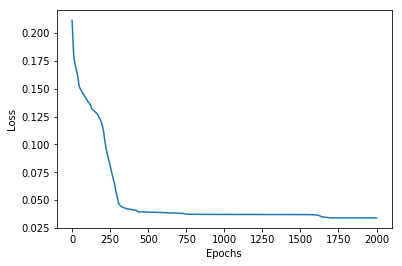

In [33]:
sn.fit(X_scaled_train, Y_scaled_train, epochs=2000, lr=0.015, display_loss=True)

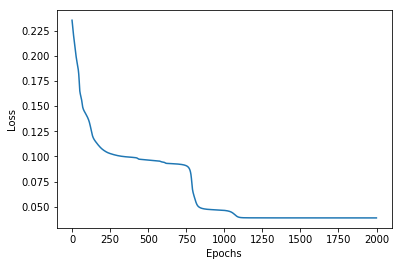

In [34]:
sn.fit(X_scaled_train, Y_scaled_train, epochs=2000, lr=0.01, display_loss=True)

In [36]:
#Note : If for a  lower values of lr, if you see that loss is saturating after certain number of epochs
#       perhaps, you could try a slightly higher learning rate and see if loss dips further

Future tasks
1. Explain what Standardscaler fit and transform do
2. Formulae for StandardScaler and MinMaxScaler
3. Why StandardScaler helps bring everything to same range and range os SS
4. Deivations for grad_w and grad_b
5. Using tqdm notebook to see progress bar
6. Show what happens for different values of learning rates and different epochs
7. Create HTML animation 